In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def hough_circle_transform(edges, r_min, r_max, threshold=100):
    """
    edges    : Kenar tespiti uygulanmış ikili (binary) görüntü (Canny veya benzeri).
    r_min    : En küçük çember yarıçapı.
    r_max    : En büyük çember yarıçapı.
    threshold: Bir 'merkez-yarıçap' kombinasyonunun geçerli sayılabilmesi için
               accumulator'da sahip olması gereken minimum oy (vote) sayısı.
    
    return: tespit edilen çemberlerin (center_x, center_y, radius) listesi
    """
    # Görüntü boyutları
    height, width = edges.shape
    
    # 3 boyutlu accumulator (b, a, r) oluşturuyoruz
    # OpenCV'nin aksine parametre olarak "dp" vs. kullanmıyoruz, en basit hali:
    accumulator = np.zeros((height, width, r_max+1), dtype=np.uint64)
    
    # Kenar piksellerini bul
    edge_points = np.argwhere(edges > 0)  # edges üzerinde >0 olan (y,x) noktalar

    # Radyanlara dönüştürmek için yardımcı
    # 0° ile 359° arasındaki açıları 1° aralıklarla alıyoruz (isteğe göre ayarlanabilir)
    thetas = np.deg2rad(np.arange(0, 360))
    
    # Kenar pikselleri üzerinde dolaş
    for y, x in edge_points:
        # r_min ile r_max arasındaki her r için merkezleri oyla
        for r in range(r_min, r_max+1):
            # r=0 ise çember manasız; isterseniz r_min'i en az 1 alabilirsiniz
            if r == 0:
                continue
            
            # Tüm açıları (0-359) gezip olası merkezleri bul
            for theta in thetas:
                a = int(x - r * np.cos(theta))
                b = int(y - r * np.sin(theta))
                
                # Merkez (a, b) görüntü sınırları içinde mi?
                if 0 <= a < width and 0 <= b < height:
                    accumulator[b, a, r] += 1
    
    # accumulator'daki değerleri 'threshold' ile kıyaslayıp çember merkezlerini seçelim
    circles = []
    
    # threshold'u aşanları bul (yani potansiyel çember merkez ve yarıçaplarını)
    # Daha hızlı bir yaklaşım isterseniz np.where ile de bakabilirsiniz ama
    # temel anlaşılır kod olarak döngü yazıyoruz.
    for b in range(height):
        for a in range(width):
            for r in range(r_min, r_max+1):
                if accumulator[b, a, r] >= threshold:
                    # Burada ayrıca local maximum kontrolü ile
                    # aynı bölgede daha yüksek oy alan var mı diye bakabilirsiniz.
                    circles.append((a, b, r))
    
    return circles


# Örnek kullanım:
if __name__ == "__main__":
    # Örnek bir gri görüntü veya kenar görüntüsü alalım
    image_path = '../datasets/image_hough_small.png'
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Kenar tespiti (Canny) yapalım
    edges = cv2.Canny(gray, 50, 150)
    
    # Hough Circle Transform (elle yazılmış fonksiyon)
    found_circles = hough_circle_transform(edges, r_min=20, r_max=40, threshold=150)
    
    # Bulunan çemberlerin üzerine çizelim
    output = image.copy()
    for (cx, cy, r) in found_circles:
        # Merkez noktasına çizgi
        cv2.circle(output, (cx, cy), 2, (0, 255, 0), -1)
        # Çember çevresi
        cv2.circle(output, (cx, cy), r, (255, 0, 0), 2)

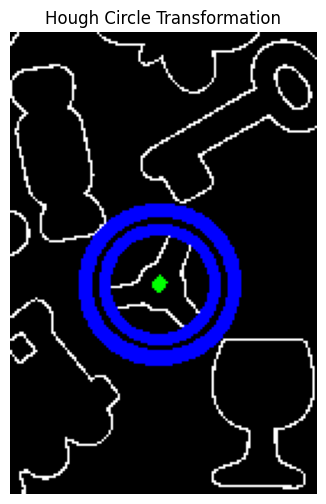

In [2]:

# Görüntüyü göster
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title("Hough Circle Transformation")
plt.axis("off")
plt.show()